# IMPORT LIBRARIES

In [1]:
import pandas as pd
import random
from pyomo.environ import *
import numpy as np
import time
import matplotlib.pyplot as plt


# IMPORT DATA

In [2]:
df = pd.read_csv(r'C:\Users\Matteo.Gabellini\OneDrive - Alma Mater Studiorum Università di Bologna\DOTTORATO\2.CONSULENZA\AZIENDE\MELONI\1.DATI\TABULAR\DatasetClean.csv')
df

,Unnamed: 0,Num. Ordine,Mese-Giorno,Articolo,Descrizione,Pezzi ordinati,Pezzi evasi,Pz x CT,Pz x TH,Volume pezzo,Volume cartone,Ecr1,Ecr2,Ecr3,Ecr4,Canale,Cliente,PV,Percorso
0,0,738378,04-18,20918,CAREFREE COTTON SALVASLIP 44 PZ.DISTESO,6,6,24,0,1.288000,33.96900,Cura Persona,Igienico Sanitari,Assorbenti,Salvaslip e Proteggislip,Piume Diretti,2104490,SM,26
1,1,738379,04-18,3456,STUDIO L.5 INVISI FIX GEL FOR.LIQ.150ml,6,6,6,0,0.378000,2.66000,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26
2,2,738379,04-18,7199,STUDIO L.8 FIX&FORCE GEL IPERFOR.150 ML.,6,6,6,0,0.303750,2.94400,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26
3,3,738379,04-18,43556,STUDIO L.9 INDESTRUC.GEL ESTREMO 150 ML,6,6,6,0,0.720000,2.81600,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26
4,4,738379,04-18,50045,STUDIO L.5 INVISI FIX GEL CR.FOR.VAS.150,6,6,6,0,0.405000,2.54375,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447292,2447292,791134,12-29,92720,CHANTECLAIR SGRASS.600 MLx2 PZ.LIMONE,1,1,6,0,3.271125,23.04000,Casa e Bucato,Superfici,Detergenti Superfici,Sgrassatori,B2C,2152842,UD,999
2447293,2447293,791134,12-29,98819,VIM GEL BAGNO 5in1 ANTICALCARE 1000 ML,1,1,12,0,1.559250,25.63600,Casa e Bucato,Bagno,Detergenti Bagno e WC,Detergenti Bagno,B2C,2152842,UD,999
2447294,2447294,791134,12-29,105877,CIF CREMA GREEN ACTIVE 500 ML PINK BLOOM,1,1,16,0,0.728000,17.02400,Casa e Bucato,Superfici,Detergenti Superfici,Detergenti Multiuso,B2C,2152842,UD,999
2447295,2447295,791134,12-29,107171,OMINO B.DET.IDROCAPS SALVAFIBRE 20pz,1,1,8,0,2.025000,20.46000,Casa e Bucato,Bucato,Detersivi Bucato,Detersivi Capsule Lavatrice,B2C,2152842,UD,999


# DEFINE FUNCTIONS

In [3]:
def initial_population(gene_space, num_genes, sol_per_pop):
    """
    Generate an initial random population.
    
    Each individual is a vector of length `num_genes`, where each gene is chosen from `gene_space`.
    
    Parameters:
        gene_space (list or array): Possible gene values.
        num_genes (int): Number of genes per individual.
        sol_per_pop (int): Number of individuals (solutions) in the population.
    
    Returns:
        np.ndarray: Population array of shape (sol_per_pop, num_genes).
    """
    return np.random.choice(gene_space, size=(sol_per_pop, num_genes))

In [4]:
gene_space = [0,1]
num_genes = df['Articolo'].nunique()
sol_per_pop = 4
population = initial_population(gene_space = gene_space, num_genes=num_genes, sol_per_pop=sol_per_pop)
population

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [5]:
def fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor,fitness_type = 'BASE'):
    """
    Compute fitness and unfitness for each individual in the population.
    
    **Fitness Calculation:**
      - For each individual, create an allocation DataFrame mapping unique 'Articolo' values
        to the individual's warehouse assignment.
      - Merge this allocation with the input DataFrame (which must contain columns 'Articolo'
        and 'Num. Ordine').
      - For each order, compute the number of transitions between warehouses (from 1 to 0 and 0 to 1).
      - The fitness is the sum of all transitions.
    
    **Unfitness Calculation:**
      - Compute the total stock assigned to Warehouse A (assignment 1) and Warehouse B (assignment 0).
      - If a warehouse's capacity is exceeded, add a penalty proportional to the excess.
    
    Parameters:
        population (np.ndarray): Array of individuals (shape: sol_per_pop x num_genes).
        stock (np.ndarray): Array of stock values associated with each 'Articolo'.
        capacity_A (float): Capacity for Warehouse A.
        capacity_B (float): Capacity for Warehouse B.
        df (pd.DataFrame): DataFrame containing order information; must include 'Articolo' and 'Num. Ordine'.
        penalty_factor (float): Penalty multiplier for capacity violations.
    
    Returns:
        tuple: Two NumPy arrays: (population_fitness, population_unfitness)
    """
    fitness_list = []
    unfitness_list = []
    unique_articles = df['Articolo'].unique()
    
    for individual in population:
        # Map each unique article to its warehouse assignment from the individual.
        df_allocation = pd.DataFrame({'Articolo': unique_articles, 'Warehouse': individual})
        # Merge the allocation with the main DataFrame.
        df_merged = pd.merge(df, df_allocation, on='Articolo', how='left')
        
        if fitness_type == 'BASE':
            
            individual_fitness = df_merged.groupby('Num. Ordine')['Warehouse'].nunique().sum() - df['Num. Ordine'].nunique()

        else:
        
            # Compute transitions within each order.
            df_merged['prev_warehouse'] = df_merged.groupby('Num. Ordine')['Warehouse'].shift(1)
            df_merged['transition_0_after_1'] = ((df_merged['prev_warehouse'] == 1) & (df_merged['Warehouse'] == 0)).astype(int)
            df_merged['transition_1_after_0'] = ((df_merged['prev_warehouse'] == 0) & (df_merged['Warehouse'] == 1)).astype(int)
            result = df_merged.groupby('Num. Ordine')[['transition_0_after_1', 'transition_1_after_0']].sum()
            individual_fitness = result.sum().sum()
            
        fitness_list.append(individual_fitness)
        
        # Calculate total stock for each warehouse.
        total_A = np.sum(individual * stock)
        total_B = np.sum((1 - individual) * stock)
        penalty = 0
        if total_A > capacity_A:
            penalty += penalty_factor * (total_A - capacity_A)
        if total_B > capacity_B:
            penalty += penalty_factor * (total_B - capacity_B)
        unfitness_list.append(penalty)
        
    return np.array(fitness_list), np.array(unfitness_list)

In [6]:
# stock = np.ones(num_genes) 
stock = np.zeros(num_genes)
# capacity_A = 0 
# capacity_B = 0 
capacity_A = 999999999999999
capacity_B = 999999999999999
penalty_factor = 1

In [7]:
population_fitness, population_unfitness = fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor)
population_fitness, population_unfitness

(array([59606, 59635, 59801, 59532], dtype=int64), array([0, 0, 0, 0]))

In [8]:
# 3. PARENT SELECTION CRITERIA
def ParentSelection(population, sol_per_pop, population_fitness, population_unfitness):
    """
    Select two parents using tournament selection.
    
    Four unique individuals are chosen at random. Among the first two candidates, the one with
    lower fitness is chosen as the first parent. Similarly, among the next two, the one with lower
    fitness is chosen as the second parent.
    
    Parameters:
        population (np.ndarray): Population array.
        sol_per_pop (int): Total number of individuals in the population.
        population_fitness (np.ndarray): Fitness values for the population.
        population_unfitness (np.ndarray): Unfitness values for the population (not used here).
    
    Returns:
        tuple: Two parents (each a 1D numpy array).
    """
    random_indices = np.random.choice(np.arange(sol_per_pop), 4, replace=False)
    # print('random_indices',random_indices)
    
    # Compare first two candidates.
    if population_fitness[random_indices[0]] >= population_fitness[random_indices[1]]:
        first_parent = population[random_indices[1]]
    else:
        first_parent = population[random_indices[0]]
    
    # Compare the next two candidates.
    if population_fitness[random_indices[2]] >= population_fitness[random_indices[3]]:
        second_parent = population[random_indices[2]]
    else:
        second_parent = population[random_indices[3]]
    
    return first_parent, second_parent

In [9]:
parent1, parent2 = ParentSelection(population, sol_per_pop, population_fitness, population_unfitness)
parent1, parent2

(array([0, 1, 1, ..., 0, 0, 1]), array([1, 0, 1, ..., 0, 0, 0]))

In [10]:
def child_generation(parent1, parent2):
    """
    Generate a child individual via one-point crossover followed by a mutation.
    
    **Crossover:** A random crossover index is selected, and the child's genes are taken 
    from parent1 up to this index and from parent2 thereafter.
    
    **Mutation:** Two random positions in the child's gene sequence are swapped.
    
    Parameters:
        parent1 (np.ndarray): First parent's gene sequence.
        parent2 (np.ndarray): Second parent's gene sequence.
    
    Returns:
        np.ndarray: The generated child individual.
    """
    child = parent2.copy()
    crossover_index = random.randint(1, len(parent1) - 1)
    child[:crossover_index] = parent1[:crossover_index]
    
    # Mutation: Swap two random indices.
    mutation_indices = np.random.choice(len(child), size=2, replace=False)
    child[mutation_indices[0]], child[mutation_indices[1]] = child[mutation_indices[1]], child[mutation_indices[0]]
    
    return child

In [11]:
parent1

array([0, 1, 1, ..., 0, 0, 1])

In [12]:
parent2

array([1, 0, 1, ..., 0, 0, 0])

In [13]:
child = child_generation(parent1 = parent1, parent2=parent2)
child

array([0, 1, 1, ..., 0, 0, 0])

In [14]:
#2.COMPUTE FITNESS AND UNFITNESS
def update_fitness_unfitness_func(population, df, stock, population_fitness, population_unfitness, child, worse_individual_index,fitness_type = 'BASE'):
    

    #CHILD IMPROVEMENT

    

    #FITNESS FUNCTION


    unique_articles = df['Articolo'].unique()
    df_allocation = pd.DataFrame({'Articolo': unique_articles, 'Warehouse': child})
    # Merge the allocation with the main DataFrame.
    df_merged = pd.merge(df, df_allocation, on='Articolo', how='left')
    
    if fitness_type == 'BASE':
        
        new_individual_fitness = df_merged.groupby('Num. Ordine')['Warehouse'].nunique().sum() - df['Num. Ordine'].nunique()

    else:
    
        # Compute transitions within each order.
        df_merged['prev_warehouse'] = df_merged.groupby('Num. Ordine')['Warehouse'].shift(1)
        df_merged['transition_0_after_1'] = ((df_merged['prev_warehouse'] == 1) & (df_merged['Warehouse'] == 0)).astype(int)
        df_merged['transition_1_after_0'] = ((df_merged['prev_warehouse'] == 0) & (df_merged['Warehouse'] == 1)).astype(int)
        result = df_merged.groupby('Num. Ordine')[['transition_0_after_1', 'transition_1_after_0']].sum()
        new_individual_fitness = result.sum().sum()
    
    population_fitness[worse_individual_index] = new_individual_fitness.reshape(1)

    #UNFITNESS FUNCTION

    total_A = np.sum(child * stock)
    total_B = np.sum((1 - child) * stock)
    penalty = 0
    if total_A > capacity_A:
        penalty += penalty_factor * (total_A - capacity_A)
    if total_B > capacity_B:
        penalty += penalty_factor * (total_B - capacity_B)

    new_individual_unfitness = penalty

    population_unfitness[worse_individual_index] = new_individual_unfitness

    return population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness



In [15]:
def new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor):
    """
    Update the population by replacing the worst individual with the new child.
    
    If all individuals have zero unfitness, the worst is determined by the highest fitness;
    otherwise, the worst is determined by the highest unfitness.
    
    After replacement, the fitness and unfitness of the entire population are re-calculated.
    
    Parameters:
        population (np.ndarray): Current population.
        child (np.ndarray): New child individual.
        stock (np.ndarray): Stock values.
        capacity_A (float): Capacity for Warehouse A.
        capacity_B (float): Capacity for Warehouse B.
        population_fitness (np.ndarray): Fitness values for the population.
        population_unfitness (np.ndarray): Unfitness values for the population.
        df (pd.DataFrame): DataFrame containing order information.
        penalty_factor (float): Penalty multiplier.
    
    Returns:
        tuple: Updated (population, population_fitness, population_unfitness,
                best_individual, best_individual_fitness, best_individual_unfitness).
    """
    if np.all(population_unfitness == 0):
        worse_individual_index = np.argmax(population_fitness)
    else:
        worse_individual_index = np.argmax(population_unfitness)
    
    population[worse_individual_index] = child

    population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness  = update_fitness_unfitness_func(population, df, stock, population_fitness, population_unfitness, child, worse_individual_index,fitness_type = 'BASE')

    
    best_idx = np.argmin(population_fitness)
    best_individual = population[best_idx]
    best_individual_fitness = population_fitness[best_idx]
    best_individual_unfitness = population_unfitness[best_idx]
    
    return population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness

In [16]:
population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness = new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor)
population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness

(array([[0, 1, 1, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0]]),
 array([59606, 59635, 59599, 59532], dtype=int64),
 array([0, 0, 0, 0]),
 59599,
 0,
 array([0, 0, 0, ..., 1, 1, 0]),
 59532,
 0)

In [17]:
# 6. MAIN GENETIC ALGORITHM LOOP WITH PLOTTING EVERY MINUTE ON DUAL Y-AXES
def main(day, gene_space, num_genes, sol_per_pop, df, stock, capacity_A, capacity_B, M, penalty_factor):
    non_improving_iteration = 0
    iteration = 0
    child_list = []
    start_time = time.time()
    last_plot_time = start_time  # Initialize last plot time
    
    # History lists.
    fitness_history = []
    unfitness_history = []
    iterations = []
    A_code_history = []
    B_code_history = []
    
    # INITIAL POPULATION
    population = initial_population(gene_space, num_genes, sol_per_pop)
    population_fitness, population_unfitness = fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor)
    
    while non_improving_iteration < M and (time.time() - start_time) < 5 * 60:
        iteration += 1
        
        # PARENT SELECTION.
        first_parent, second_parent = ParentSelection(population, sol_per_pop, population_fitness, population_unfitness)
        
        # CHILD GENERATION.
        child = child_generation(first_parent, second_parent)
        
        # POPULATION UPDATE.
        (population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness) = new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor)

        #VISUALIZE NUMBER OF CODE PER WAREHOUSE 
        unique_articles = df['Articolo'].unique()
        df_allocation = pd.DataFrame({'Articolo': unique_articles, 'Warehouse': best_individual})
        df_merged = pd.merge(df, df_allocation, on='Articolo', how='left')
        A_code = list(df_merged.groupby('Warehouse')['Articolo'].nunique())[0]
        B_code = df_merged['Articolo'].nunique() - list(df_merged.groupby('Warehouse')['Articolo'].nunique())[0]
        
        # Record history.
        fitness_history.append(best_individual_fitness)
        unfitness_history.append(best_individual_unfitness)
        iterations.append(iteration)
        A_code_history.append(A_code)
        B_code_history.append(B_code)
        
        # Plot every 60 seconds on the same figure with two y-axes.
        current_time = time.time()
        if current_time - last_plot_time >= 10:
            # Assume the following lists have been populated during the algorithm:
            # iterations, fitness_history, unfitness_history, A_code_history, B_code_history
            
            fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Left subplot: Fitness and Unfitness Evolution
            # Plot best fitness on the primary y-axis.
            ax_left.plot(iterations, fitness_history, 'o-', color='blue', label='Best Fitness')
            ax_left.set_xlabel('Iteration')
            ax_left.set_ylabel('Best Fitness', color='blue')
            ax_left.tick_params(axis='y', labelcolor='blue')
            # Create a twin y-axis to plot best unfitness.
            ax_left_right = ax_left.twinx()
            ax_left_right.plot(iterations, unfitness_history, 'o-', color='red', label='Best Unfitness')
            ax_left_right.set_ylabel('Best Unfitness', color='red')
            ax_left_right.tick_params(axis='y', labelcolor='red')
            ax_left.set_title("Evolution of Fitness and Unfitness")
            ax_left.grid(True)
            
            # Right subplot: Code A and Code B Evolution
            # Plot Code A on the primary y-axis.
            ax_right.plot(iterations, A_code_history, 'o-', color='green', label='Code A')
            ax_right.set_xlabel('Iteration')
            ax_right.set_ylabel('Code A', color='green')
            ax_right.tick_params(axis='y', labelcolor='green')
            # Create a twin y-axis to plot Code B.
            ax_right_right = ax_right.twinx()
            ax_right_right.plot(iterations, B_code_history, 'o-', color='purple', label='Code B')
            ax_right_right.set_ylabel('Code B', color='purple')
            ax_right_right.tick_params(axis='y', labelcolor='purple')
            ax_right.set_title("Evolution of Code A and Code B")
            ax_right.grid(True)
            
            fig.tight_layout()
            plt.show()
    
            last_plot_time = current_time
        
        # Check for duplicate child.
        if list(child) in child_list:
            non_improving_iteration += 1
        else:
            non_improving_iteration = 0
            child_list.append(list(child))
    
    computational_time = time.time() - start_time
    
    # Final plot after the loop finishes on dual y-axes.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(iterations, fitness_history, 'o-', label='Best Fitness', color='blue')
    ax2.plot(iterations, unfitness_history, 'o-', label='Best Unfitness', color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best Fitness', color='blue')
    ax2.set_ylabel('Best Unfitness', color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title("Final Evolution of Best Individual's Fitness and Unfitness")
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    return population, population_fitness, population_unfitness, computational_time

## ALLOCATION

In [18]:
df_allocation = pd.DataFrame({'Articolo': df['Articolo'].unique()})
df_allocation['Warehouse'] = best_individual
df_allocation

,Articolo,Warehouse
0,20918,0
1,3456,0
2,7199,0
3,43556,0
4,50045,1
...,...,...
18655,75927,0
18656,103566,0
18657,107026,1
18658,107496,1


In [19]:
df_allocation.groupby('Warehouse')['Articolo'].nunique()

Warehouse
0    9298
1    9362
Name: Articolo, dtype: int64

In [20]:
gene_space = [0,1]
num_genes = df['Articolo'].nunique()
sol_per_pop = 50
penalty_factor = 1
M = 500000

stock = np.ones(num_genes) # np.random.randint(0, 100, num_genes)
capacity_A = stock.sum() * 0.7
capacity_B = stock.sum() *0.3

# stock = np.zeros(num_genes)
# capacity_A = 999999999999999
# capacity_B = 999999999999999

In [21]:
stock.sum(),capacity_A,capacity_B

(18660.0, 13062.0, 5598.0)

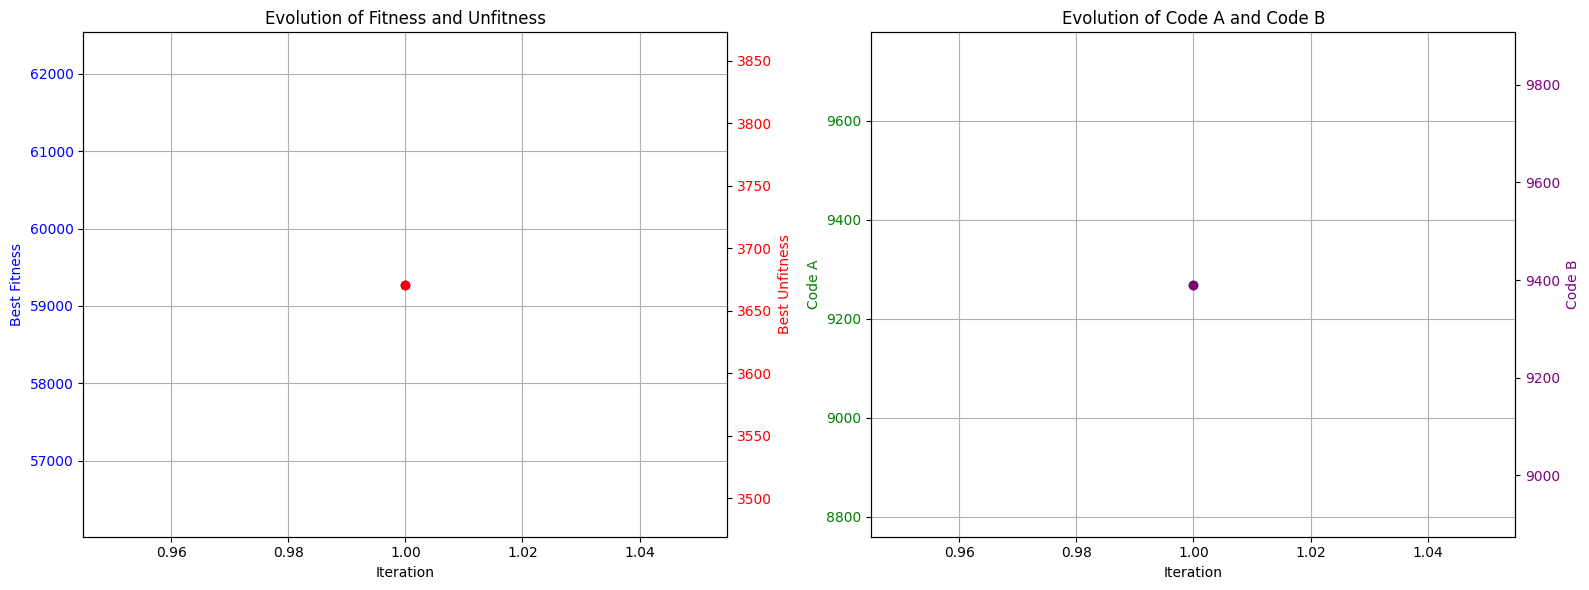

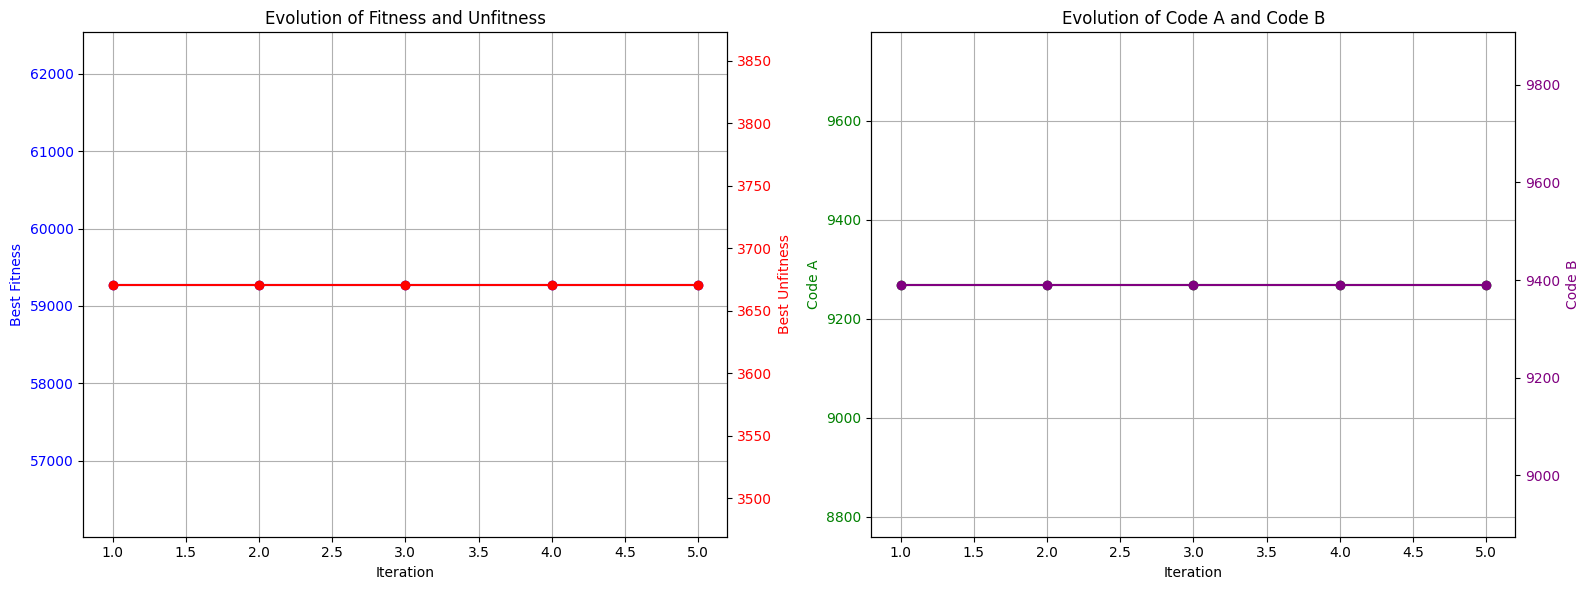

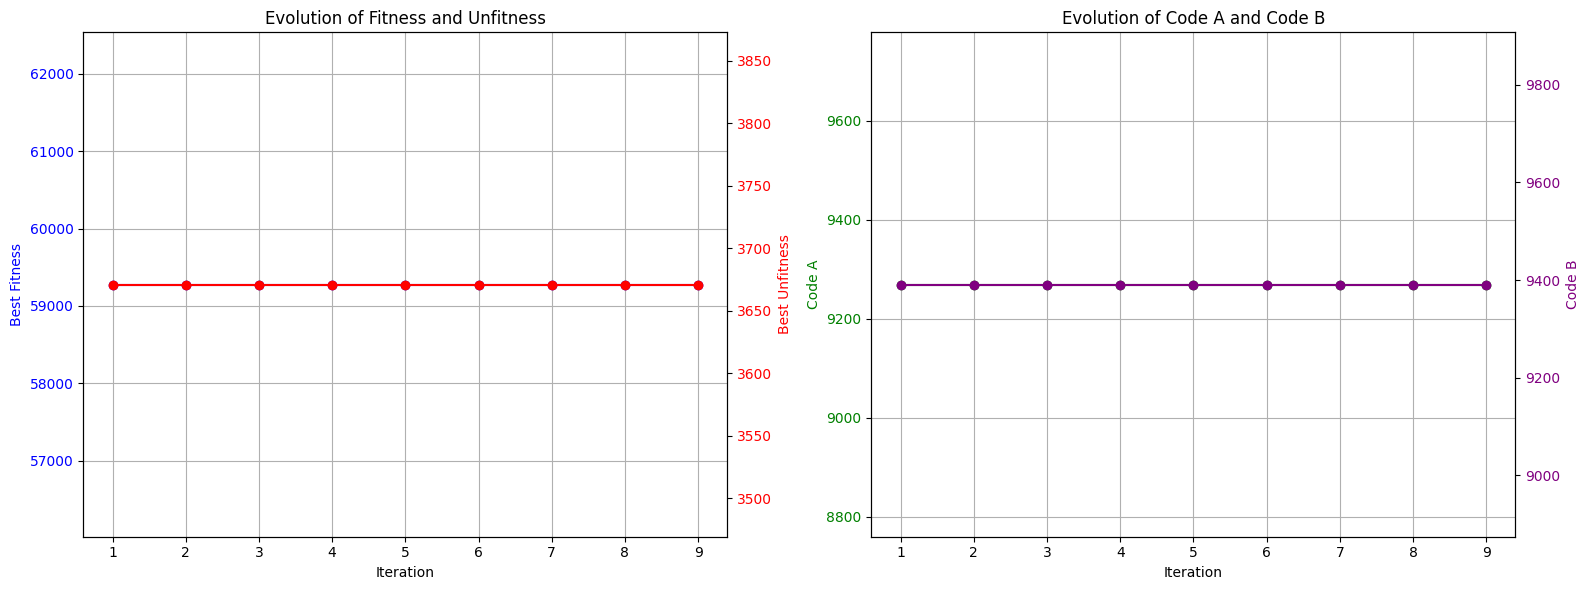

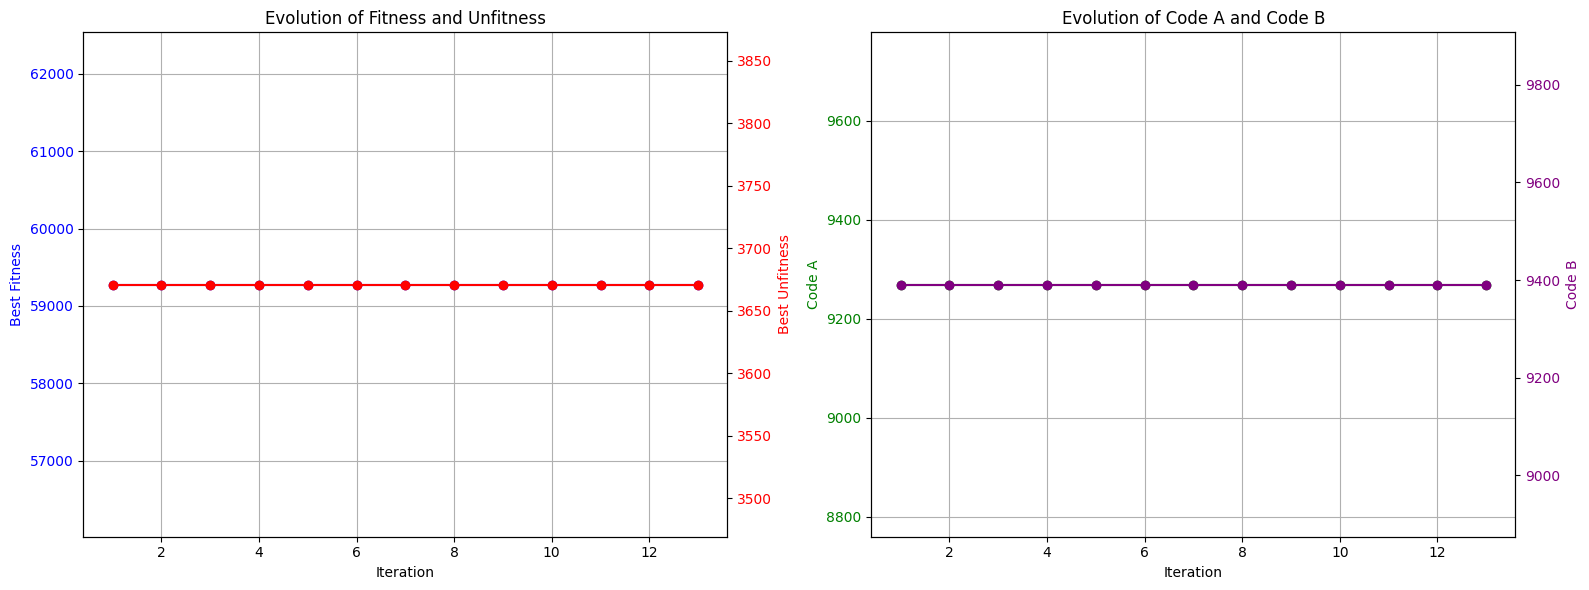

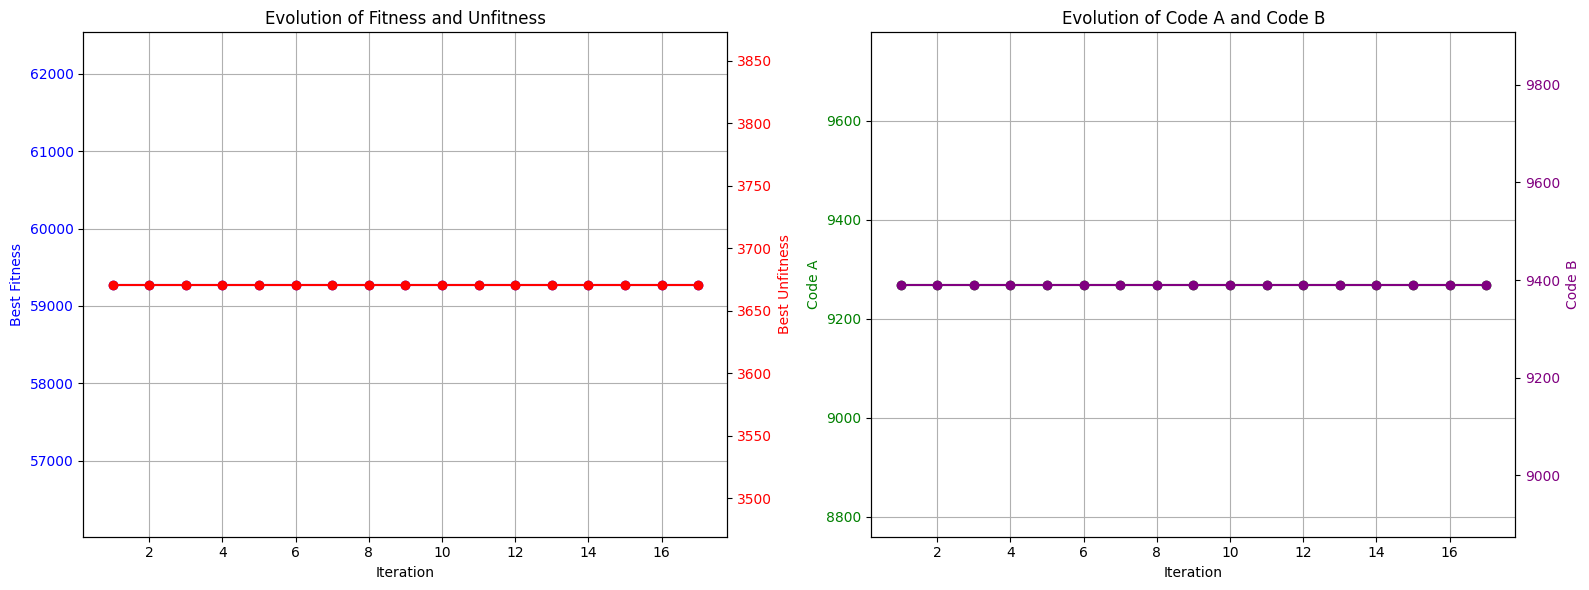

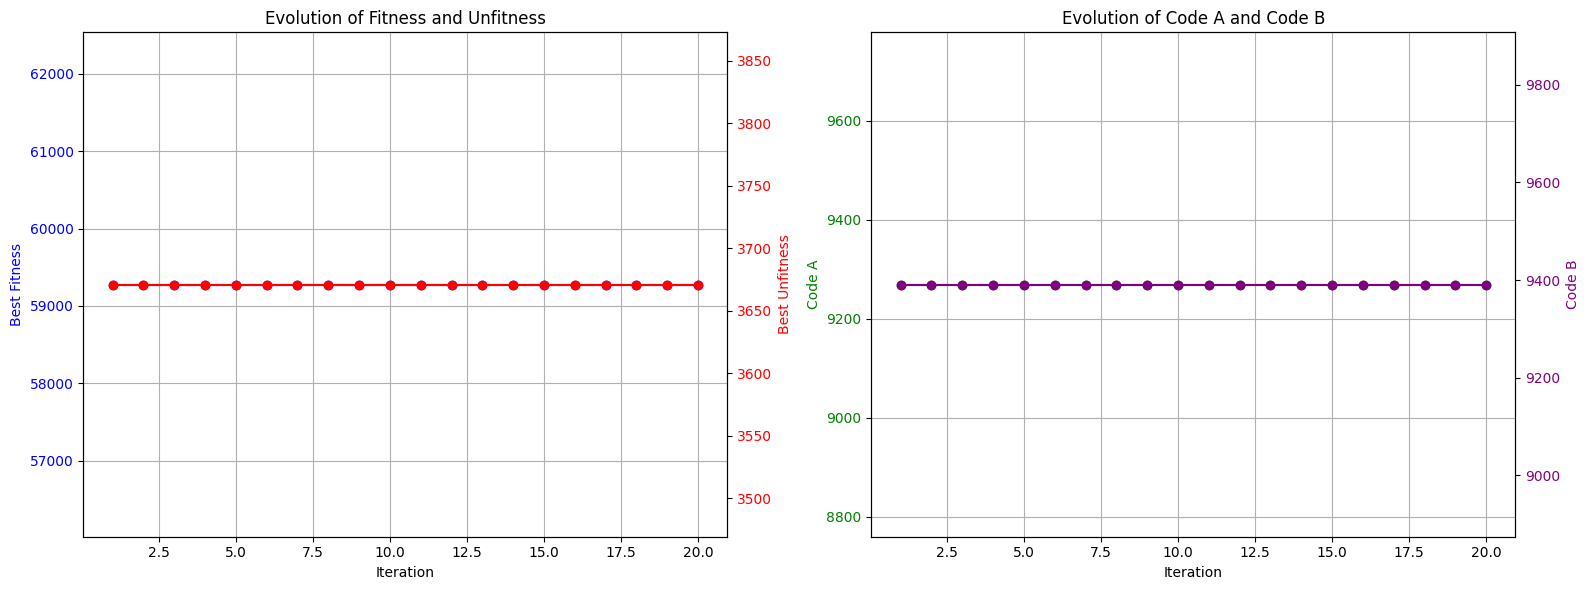

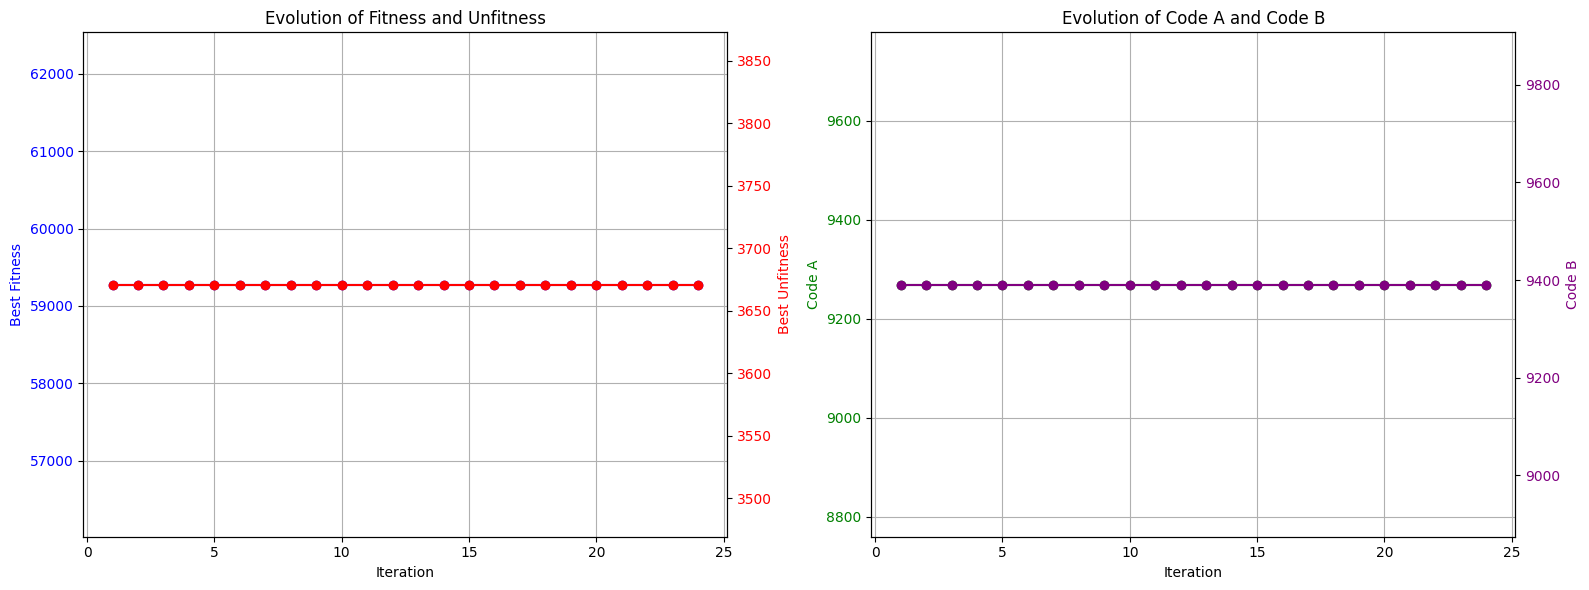

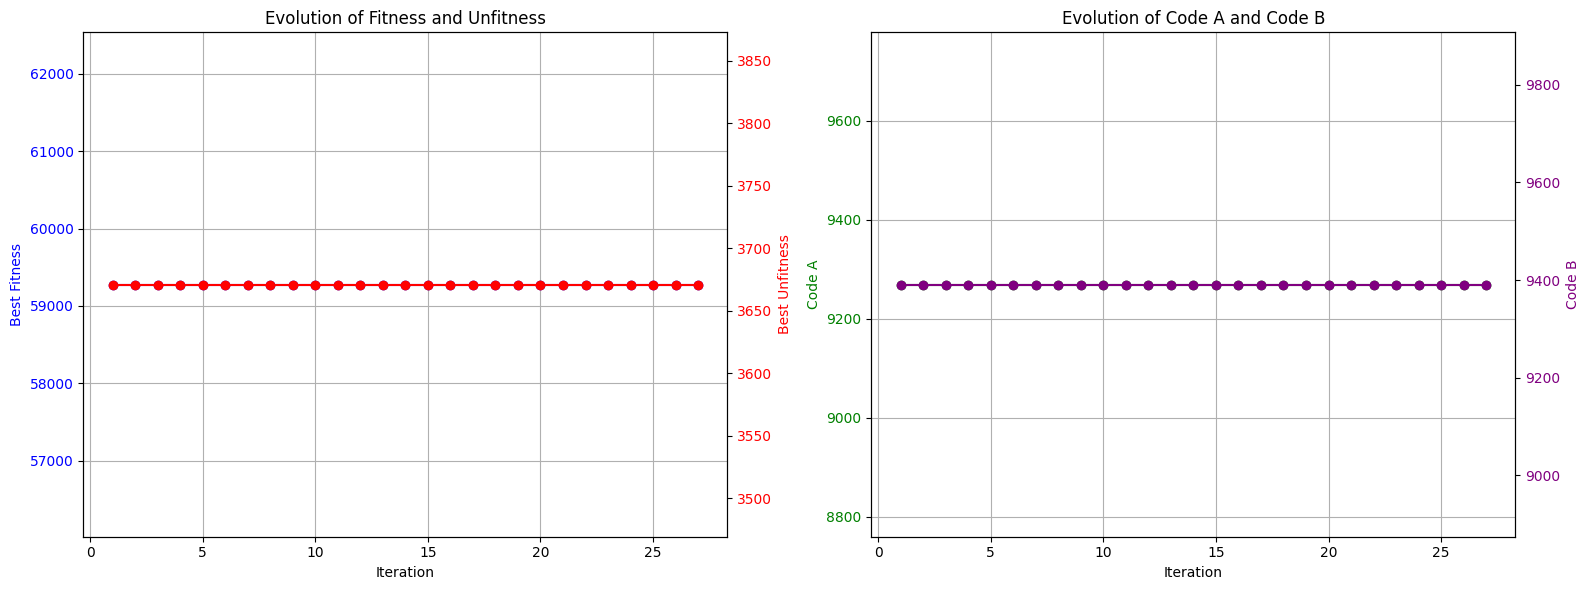

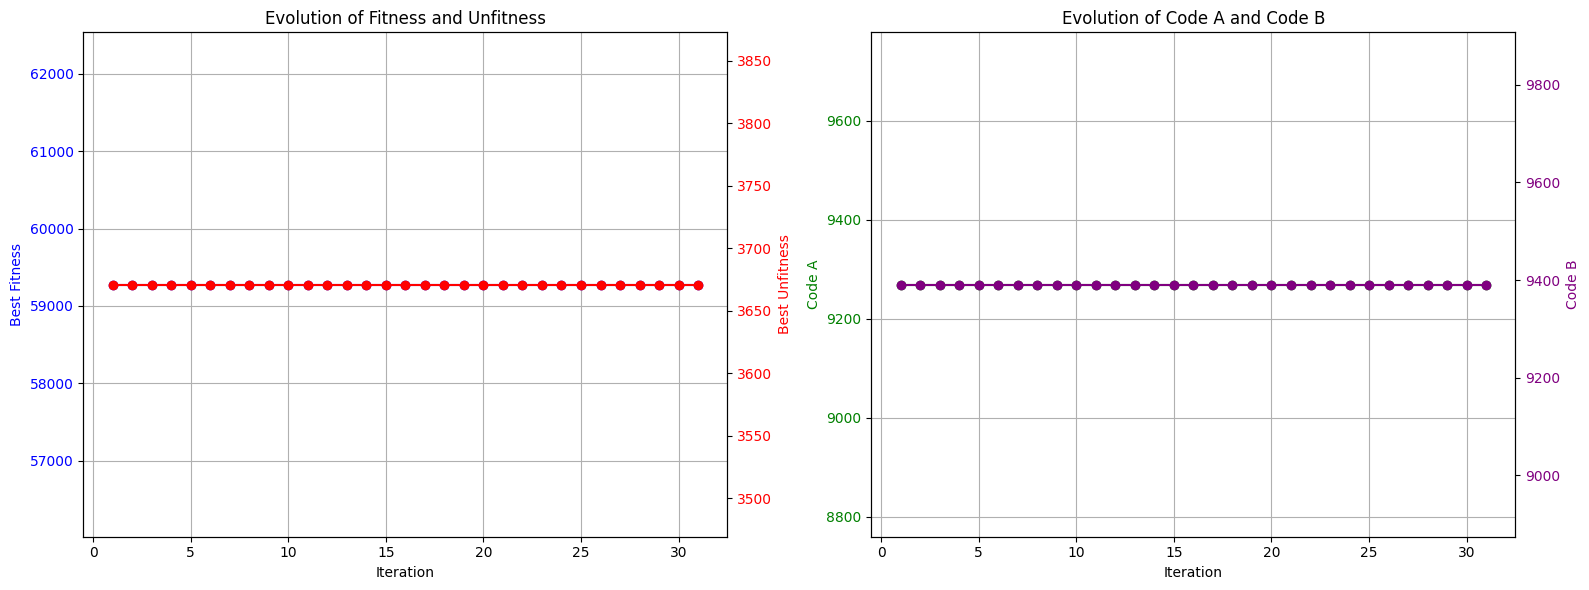

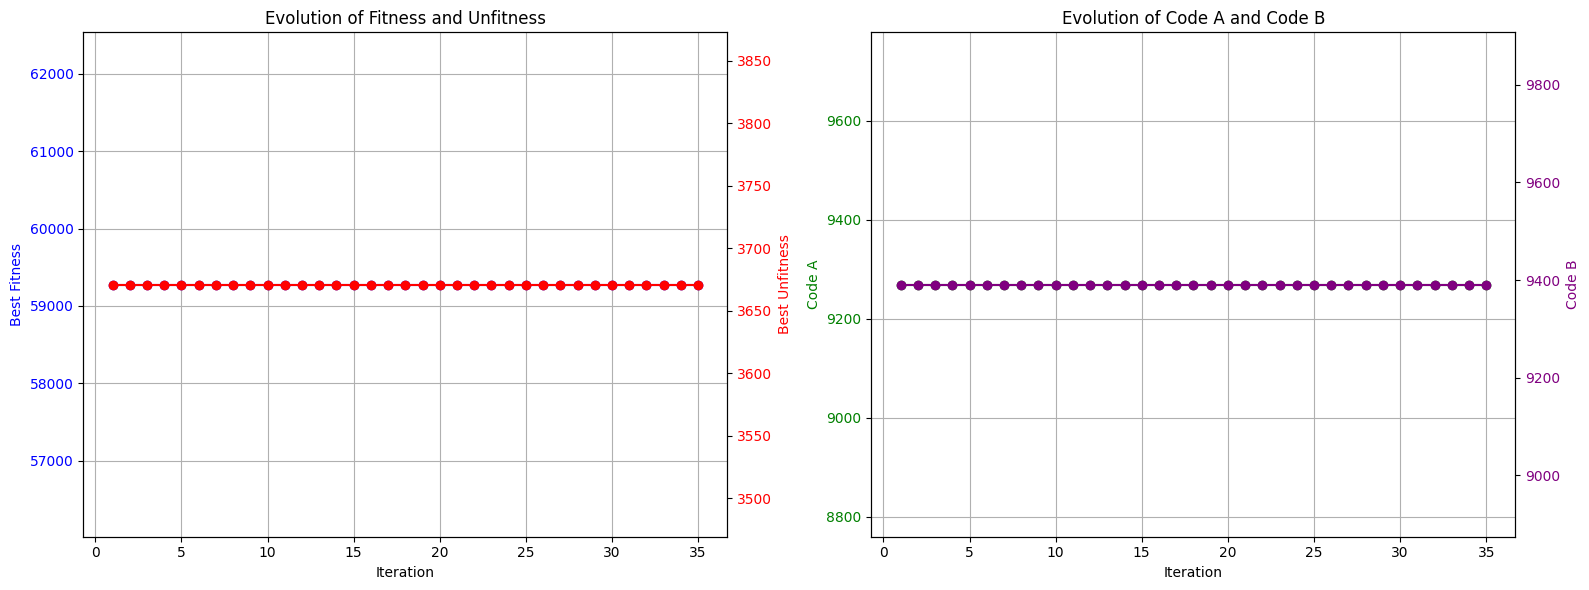

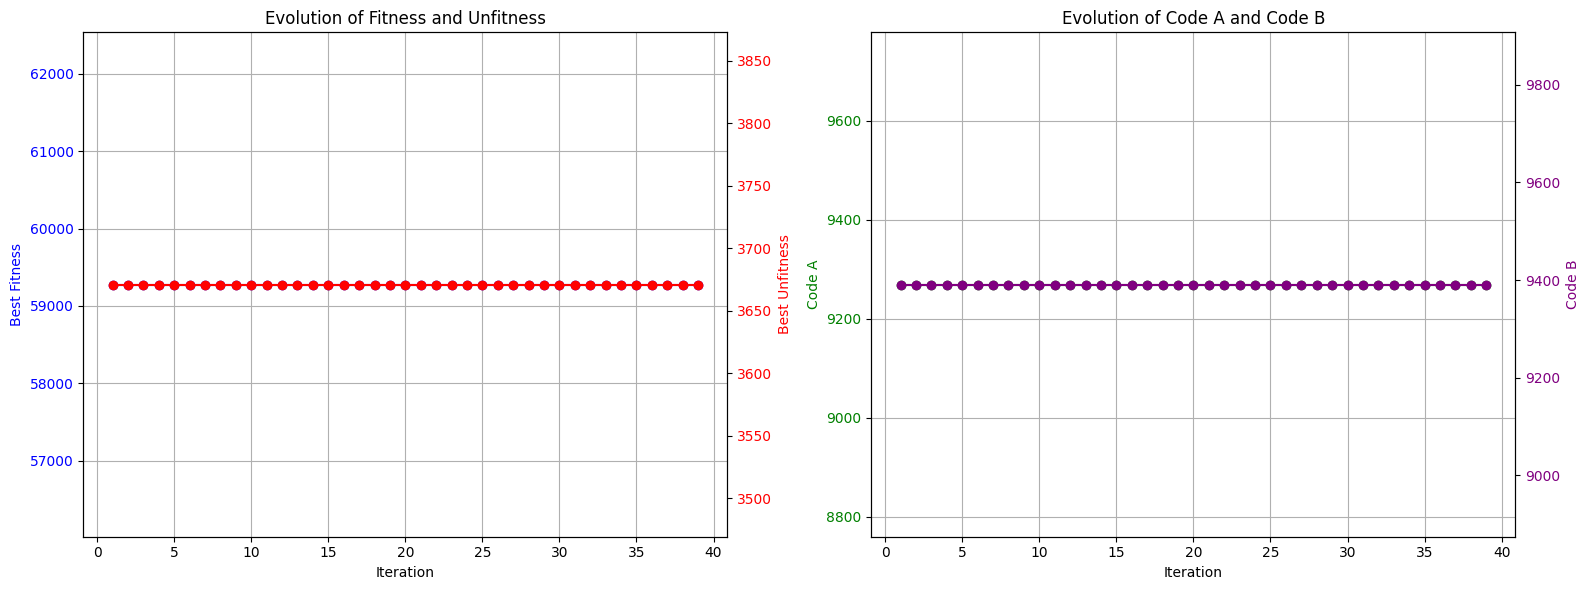

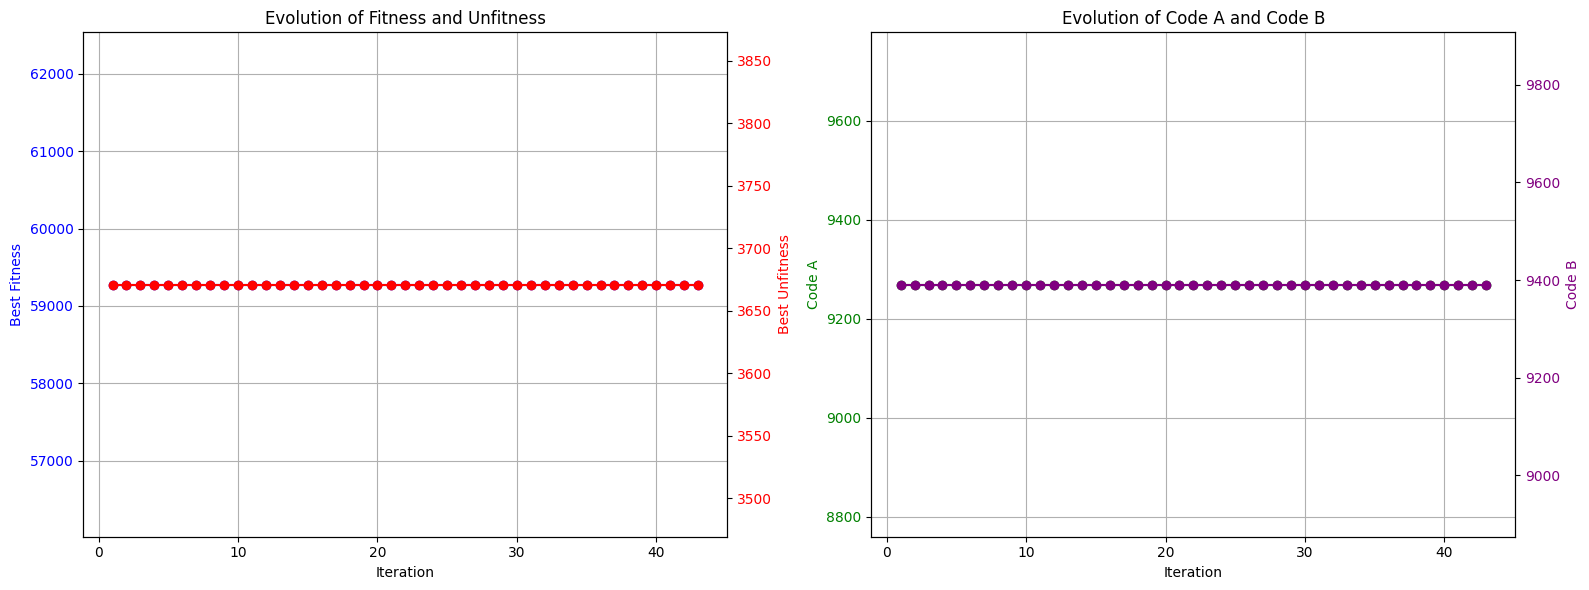

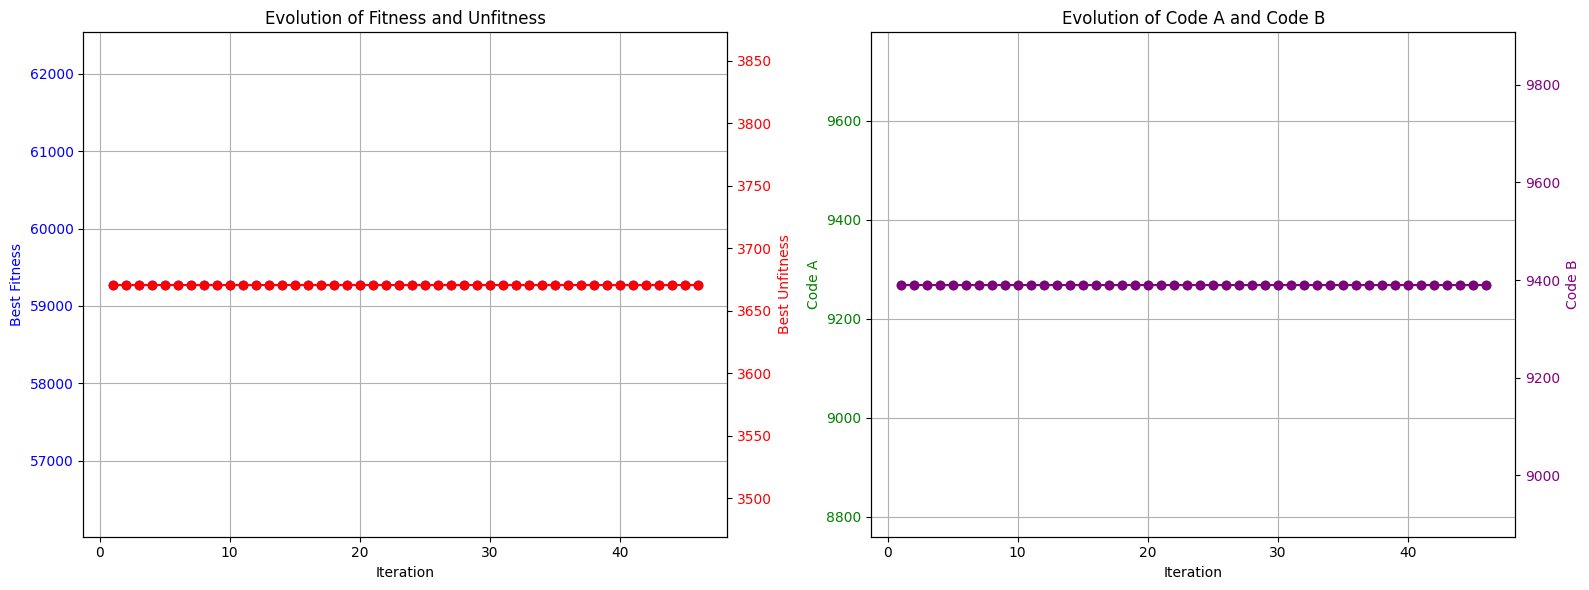

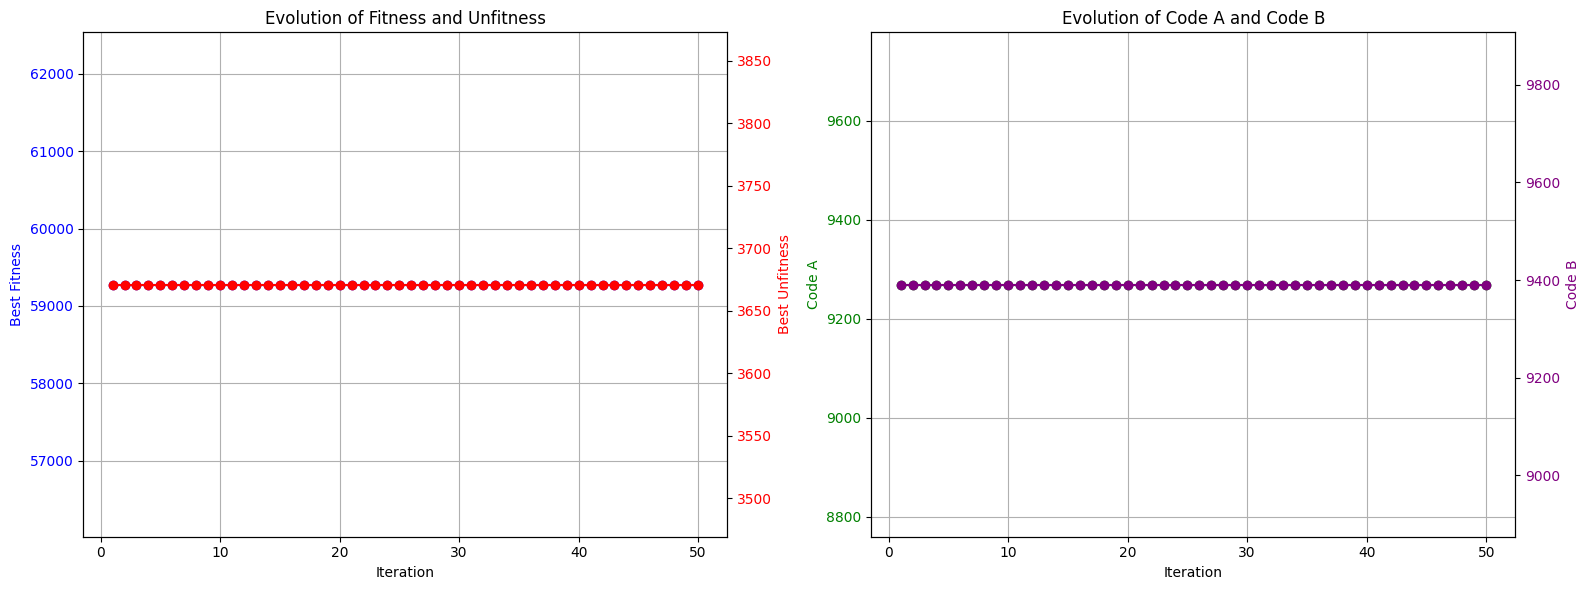

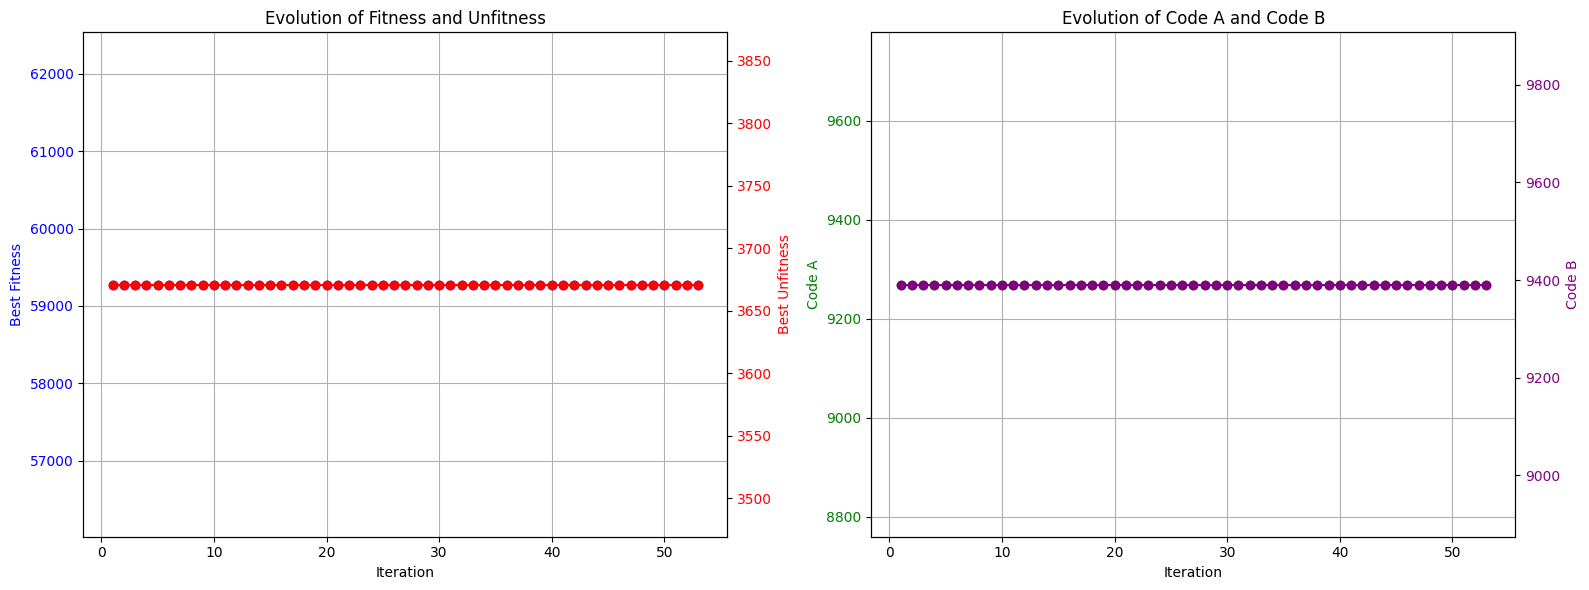

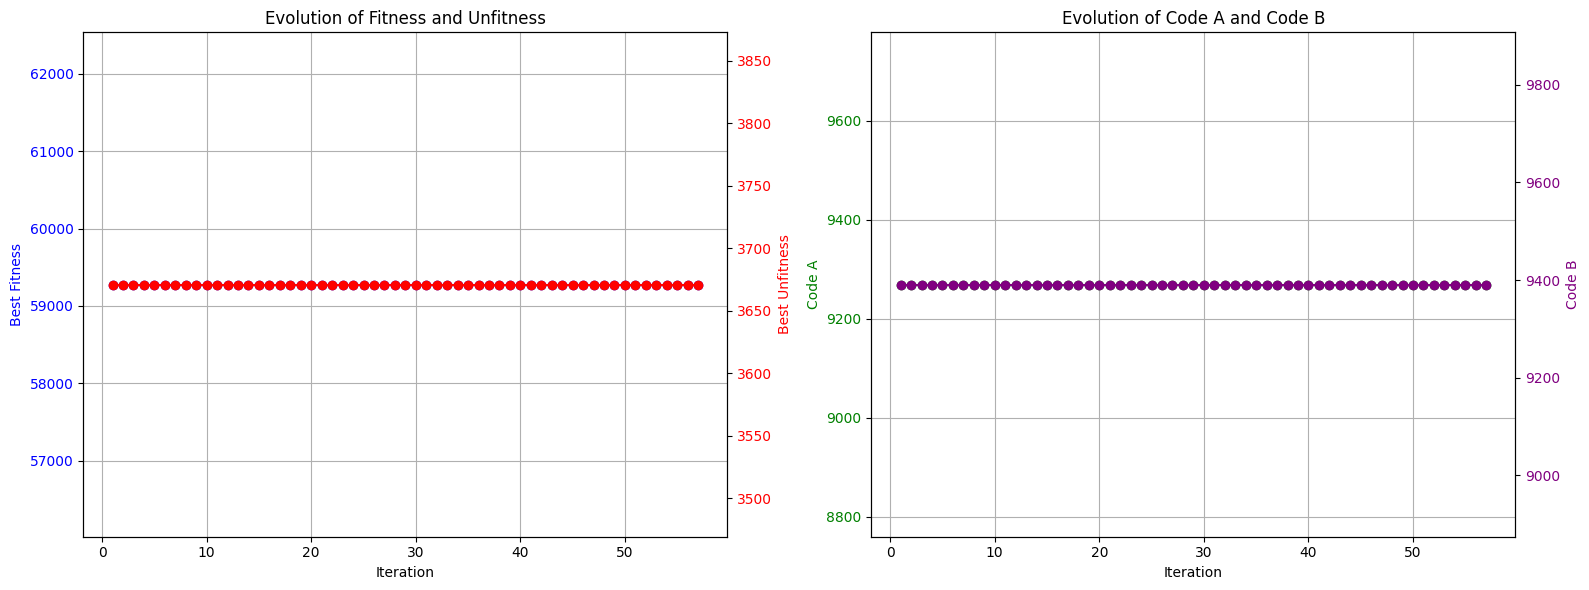

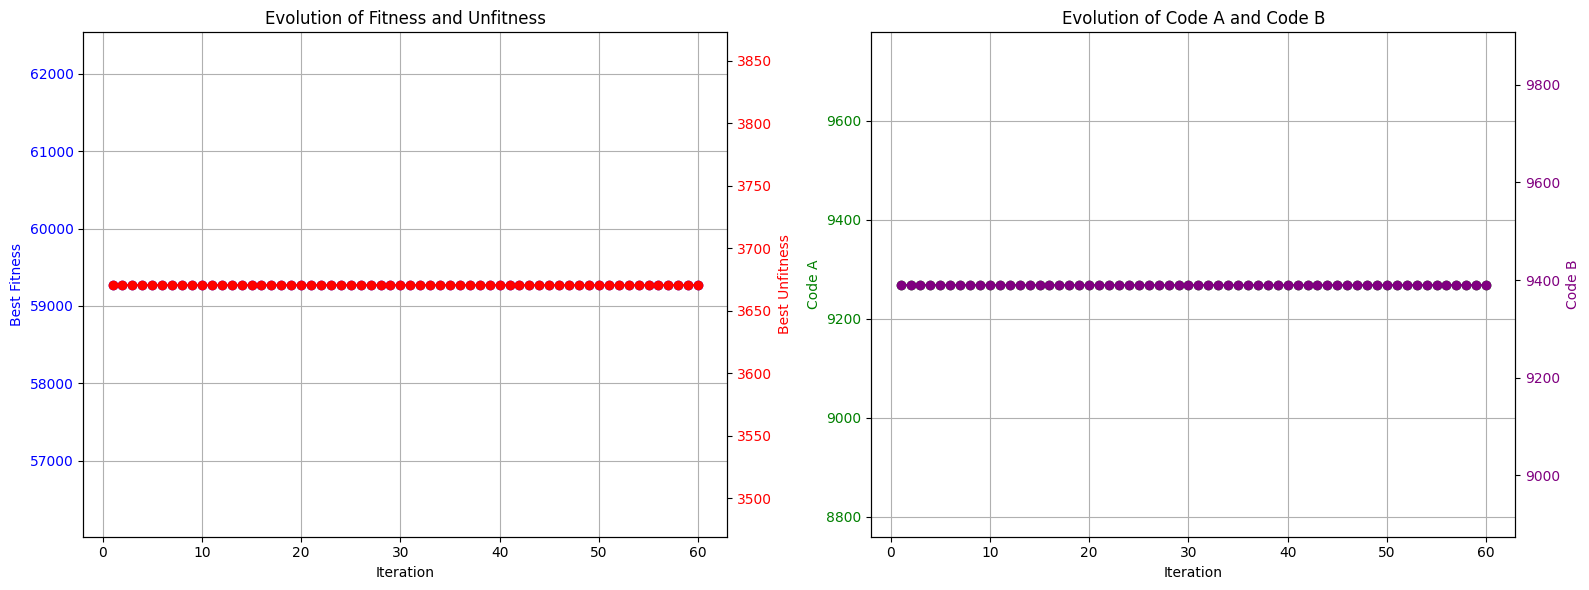

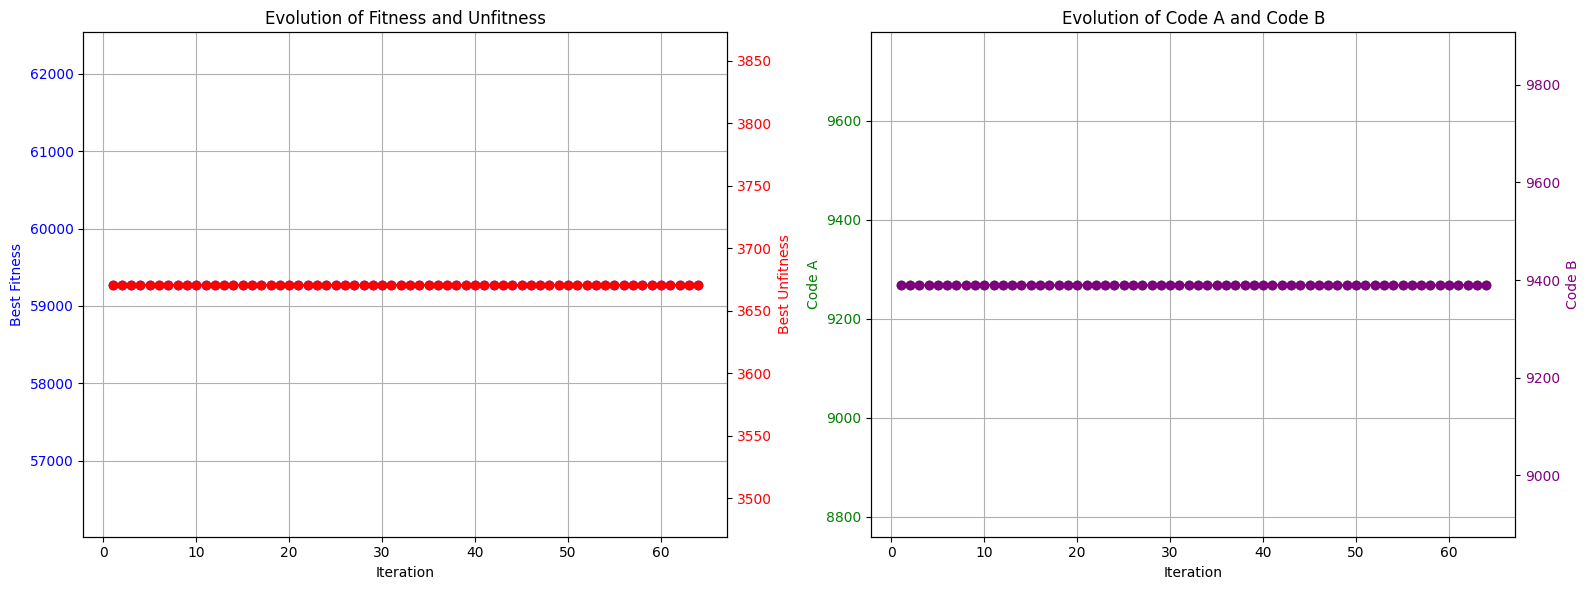

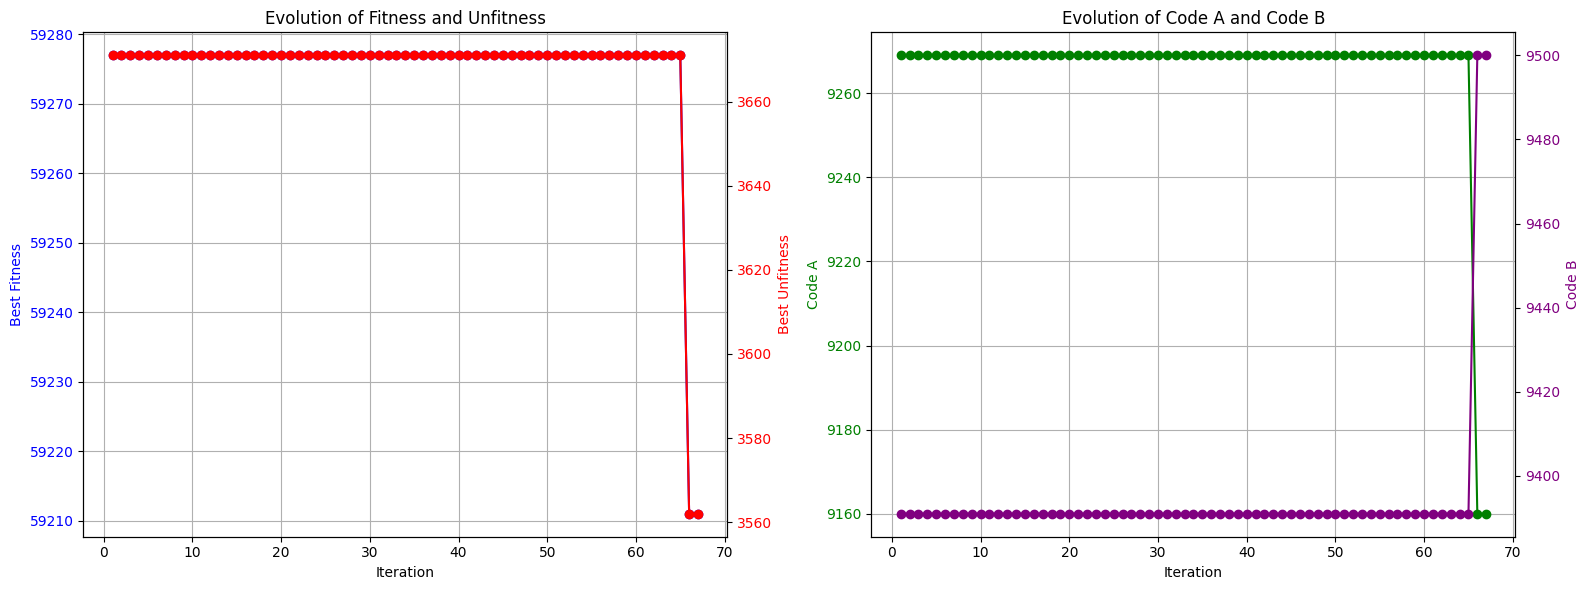

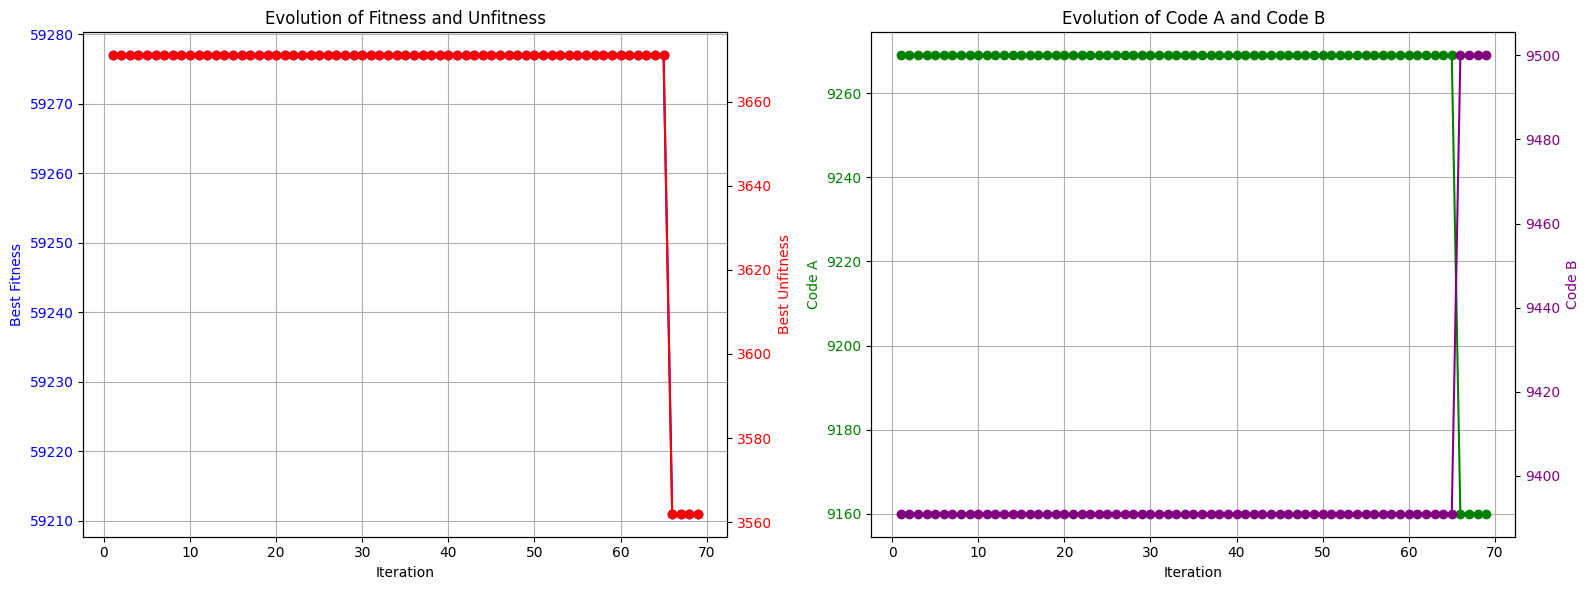

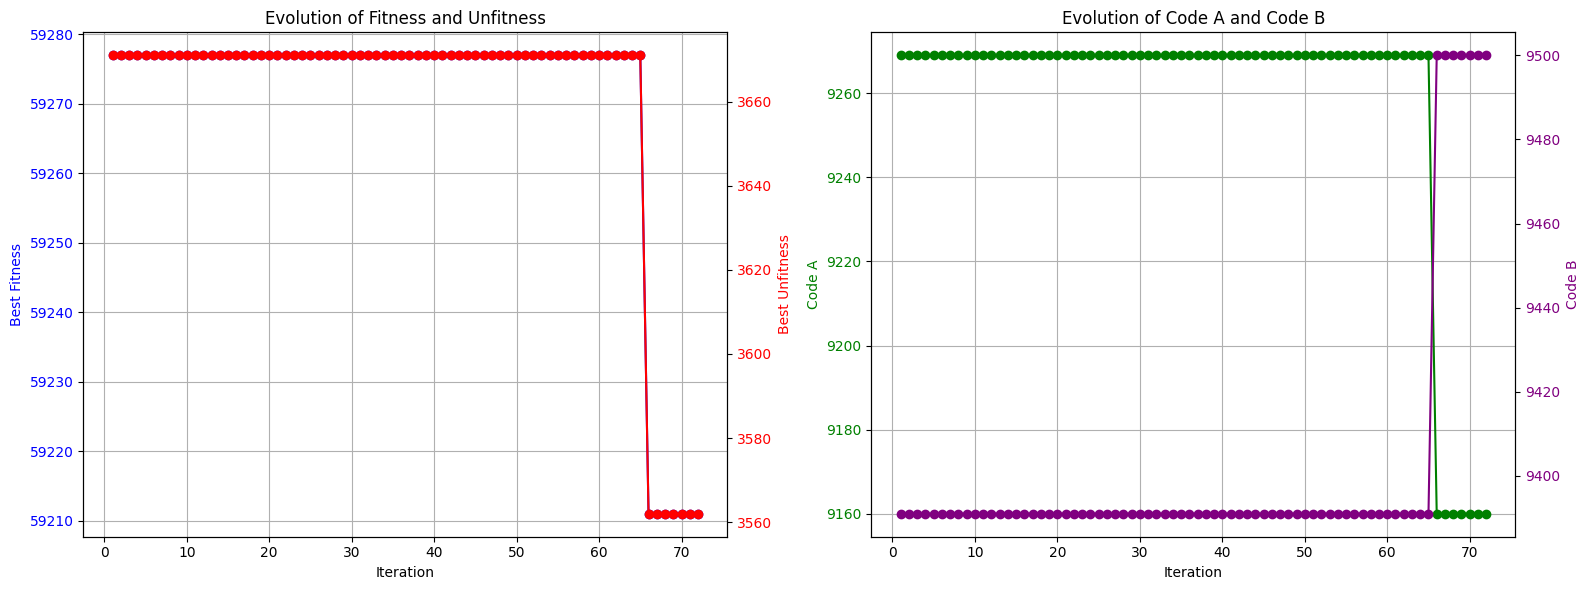

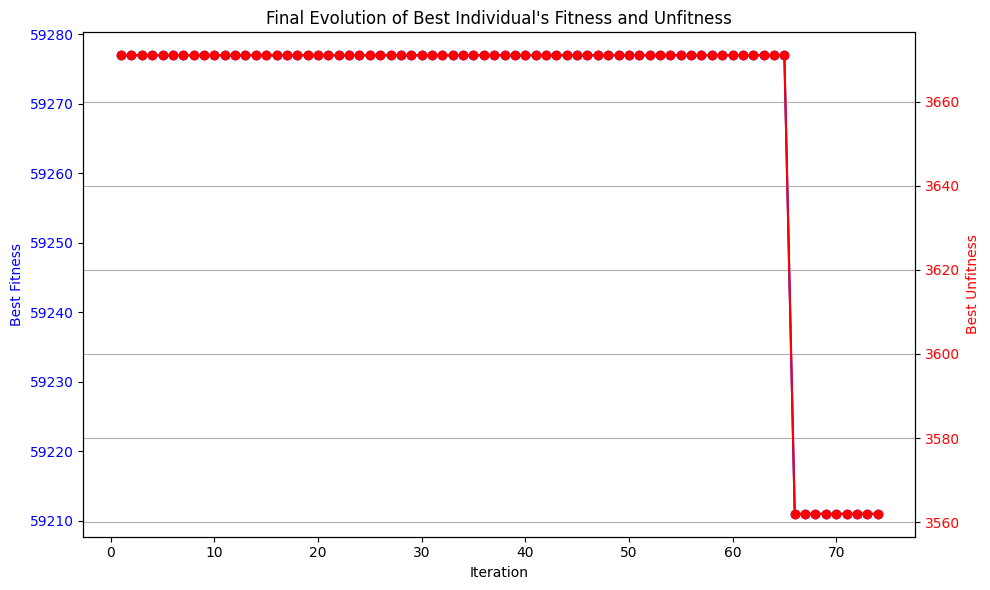

In [22]:
# Run the Genetic Algorithm.
best_population, best_fitness_values, best_unfitness_values, comp_time = main(
    day=None,
    gene_space=gene_space,
    num_genes=num_genes,
    sol_per_pop=sol_per_pop,
    df=df,
    stock=stock,
    capacity_A=capacity_A,
    capacity_B=capacity_B,
    M=M,
    penalty_factor=penalty_factor
)

In [23]:
print("Global Best Population:")
print(best_population)
print("Global Fitness Values:")
print(best_fitness_values)
print("Global Unfitness Values:")
print(best_unfitness_values)
print("Total Computational Time (sec):", comp_time)

Global Best Population:
[[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 0 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
Global Fitness Values:
[59429 59300 59513 59375 59708 59895 59967 59459 59822 59328 59596 59701
 59686 59544 59493 59779 59725 59618 59470 59408 59536 59433 59782 59567
 59607 59948 59211 59808 59665 59464 59674 59350 59302 59525 59697 59434
 59714 59514 59511 59306 59689 59649 59378 59367 59788 59473 59505 59586
 59595 59917]
Global Unfitness Values:
[3603. 3661. 3581. 3664. 3664. 3664. 3617. 3625. 3574. 3551. 3565. 3630.
 3604. 3560. 3637. 3592. 3644. 3614. 3557. 3598. 3627. 3586. 3586. 3653.
 3568. 3596. 3562. 3483. 3538. 3595. 3575. 3657. 3637. 3595. 3652. 3594.
 3619. 3663. 3661. 3627. 3643. 3663. 3573. 3650. 3592. 3633. 3658. 3644.
 3590. 3652.]
Total Computational Time (sec): 302.3386552333832


# STATISTICS

In [24]:
df = pd.merge(df, df_allocation, on='Articolo', how='left')
df

,Unnamed: 0,Num. Ordine,Mese-Giorno,Articolo,Descrizione,Pezzi ordinati,Pezzi evasi,Pz x CT,Pz x TH,Volume pezzo,Volume cartone,Ecr1,Ecr2,Ecr3,Ecr4,Canale,Cliente,PV,Percorso,Warehouse
0,0,738378,04-18,20918,CAREFREE COTTON SALVASLIP 44 PZ.DISTESO,6,6,24,0,1.288000,33.96900,Cura Persona,Igienico Sanitari,Assorbenti,Salvaslip e Proteggislip,Piume Diretti,2104490,SM,26,0
1,1,738379,04-18,3456,STUDIO L.5 INVISI FIX GEL FOR.LIQ.150ml,6,6,6,0,0.378000,2.66000,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26,0
2,2,738379,04-18,7199,STUDIO L.8 FIX&FORCE GEL IPERFOR.150 ML.,6,6,6,0,0.303750,2.94400,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26,0
3,3,738379,04-18,43556,STUDIO L.9 INDESTRUC.GEL ESTREMO 150 ML,6,6,6,0,0.720000,2.81600,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26,0
4,4,738379,04-18,50045,STUDIO L.5 INVISI FIX GEL CR.FOR.VAS.150,6,6,6,0,0.405000,2.54375,Cura Persona,Capelli,Styling Capelli,Gel e Cere Capelli,Piume Diretti,2104490,SM,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447292,2447292,791134,12-29,92720,CHANTECLAIR SGRASS.600 MLx2 PZ.LIMONE,1,1,6,0,3.271125,23.04000,Casa e Bucato,Superfici,Detergenti Superfici,Sgrassatori,B2C,2152842,UD,999,1
2447293,2447293,791134,12-29,98819,VIM GEL BAGNO 5in1 ANTICALCARE 1000 ML,1,1,12,0,1.559250,25.63600,Casa e Bucato,Bagno,Detergenti Bagno e WC,Detergenti Bagno,B2C,2152842,UD,999,0
2447294,2447294,791134,12-29,105877,CIF CREMA GREEN ACTIVE 500 ML PINK BLOOM,1,1,16,0,0.728000,17.02400,Casa e Bucato,Superfici,Detergenti Superfici,Detergenti Multiuso,B2C,2152842,UD,999,0
2447295,2447295,791134,12-29,107171,OMINO B.DET.IDROCAPS SALVAFIBRE 20pz,1,1,8,0,2.025000,20.46000,Casa e Bucato,Bucato,Detersivi Bucato,Detersivi Capsule Lavatrice,B2C,2152842,UD,999,1


In [25]:
df.groupby('Warehouse')['Articolo'].nunique()

Warehouse
0    9298
1    9362
Name: Articolo, dtype: int64

In [26]:
# Create a new column that contains the previous warehouse code within each order.
df['prev_warehouse'] = df.groupby('Num. Ordine')['Warehouse'].shift(1)

# Now create two boolean columns for the transitions:
df['transition_0_after_1'] = ((df['prev_warehouse'] == 1) & (df['Warehouse'] == 0)).astype(int)
df['transition_1_after_0'] = ((df['prev_warehouse'] == 0) & (df['Warehouse'] == 1)).astype(int)

# Group by 'Num. Ordine' and sum the transitions.
result = df.groupby('Num. Ordine')[['transition_0_after_1', 'transition_1_after_0']].sum()

result

,transition_0_after_1,transition_1_after_0
Num. Ordine,,
714001,6,6
714002,1,1
714003,67,68
714004,1,2
714005,0,0
...,...,...
801199,0,0
801200,0,0
801201,0,0


In [27]:
df[df['Num. Ordine'] == 714001]

,Unnamed: 0,Num. Ordine,Mese-Giorno,Articolo,Descrizione,Pezzi ordinati,Pezzi evasi,Pz x CT,Pz x TH,Volume pezzo,...,Ecr3,Ecr4,Canale,Cliente,PV,Percorso,Warehouse,prev_warehouse,transition_0_after_1,transition_1_after_0
2351210,2351210,714001,01-01,32175,CHANTECLAIR SGRASS.600 ML.DISINFETTANTE,1,1,12,0,1.500000,...,Detergenti Superfici,Sgrassatori,B2C,2086782,LI,999,1,NaN,0,0
2351211,2351211,714001,01-01,51930,PIUMINI RICAMBIO 10 PZ.703330,1,1,24,0,1.785000,...,Accessori Pulizia Casa,"Scope, Palette e Moci",B2C,2086782,LI,999,1,1.0,0,0
2351212,2351212,714001,01-01,37088,DAYLY IGIENICA 6 ROTOLI 4 VELI 150 STR,3,3,7,0,8.160000,...,Carta Igienica,NaN,B2C,2086782,LI,999,0,1.0,1,0
2351213,2351213,714001,01-01,3774,NICKY TOV.38x38 2 VL.45 PZ.,4,4,48,0,1.805000,...,Articoli Monouso,Tovaglioli di Carta,B2C,2086782,LI,999,0,0.0,0,0
2351214,2351214,714001,01-01,79632,TEMPO FAZZ.LIGHT 3 VL CUBOTTO 60 VELINE,4,4,12,0,1.584000,...,Fazzoletti e Veline,NaN,B2C,2086782,LI,999,1,0.0,0,1
2351215,2351215,714001,01-01,65589,REGINA BLITZ ASCIUG.ROTOLO 100 STR.3 VL,3,3,5,0,7.253568,...,Articoli Monouso,Rotoloni Asciugatutto,B2C,2086782,LI,999,1,1.0,0,0
2351216,2351216,714001,01-01,84151,CHANTECLAIR LIQ.30 LAV.MARSIGLIA,4,4,8,1,3.332000,...,Detersivi Bucato,Detersivi Liquido Lavatrice,B2C,2086782,LI,999,1,1.0,0,0
2351217,2351217,714001,01-01,94870,DERMOMED BAGNODOC.650 ML ARGAN,1,1,12,0,1.501500,...,Detergenti Corpo,Bagnoschiuma,B2C,2086782,LI,999,1,1.0,0,0
2351218,2351218,714001,01-01,94729,PIUME CANDEGGINA 1 LT,1,1,15,0,1.760000,...,Detergenti Superfici,Candeggine,B2C,2086782,LI,999,1,1.0,0,0
2351219,2351219,714001,01-01,96893,VIDAL BAGNO 500 ML EMOT.FIORI TIARÉ,1,1,12,0,0.951750,...,Detergenti Corpo,Bagnoschiuma,B2C,2086782,LI,999,1,1.0,0,0


In [28]:
result.sum().sum()

1183711

In [29]:
df_results = pd.DataFrame.from_dict(
    {
        'Magazzino A': [],
        'Magazzino B':[],
        
        'Codici in A':[],
        'Codici in B':[],
        
        'Stock [m3] in A':[],
        'Stock [m3] in B':[],
        
        '% Ordini completati in AB':[],
        '% Ordini completati in A':[], 
        '% Ordini completati in B':[],

        'Vol[m3] Ordini completati in A':[], 
        'Vol[m3] Ordini completati in B':[],
        'Vol[m3] Ordini completati in AB':[],
        'Vol[m3] Ordini completati in AB (A)':[],
        'Vol[m3] Ordini completati in AB (B)':[],
        
        '% Rotte completate in AB' :[],
        '% Rotte completate in A' :[],
        '% Rotte completate in B' :[],

        'Vol[m3] Rotte completati in A' :[],
        'Vol[m3] Rotte completati in B' :[],
        'Vol[m3] Rotte completati in AB' :[],
        'Vol[m3] Rotte completati in AB (A)' :[],
        'Vol[m3] Rotte completati in AB (B)' :[],

    }
)
df_results

,Magazzino A,Magazzino B,Codici in A,Codici in B,Stock [m3] in A,Stock [m3] in B,% Ordini completati in AB,% Ordini completati in A,% Ordini completati in B,Vol[m3] Ordini completati in A,...,Vol[m3] Ordini completati in AB (A),Vol[m3] Ordini completati in AB (B),% Rotte completate in AB,% Rotte completate in A,% Rotte completate in B,Vol[m3] Rotte completati in A,Vol[m3] Rotte completati in B,Vol[m3] Rotte completati in AB,Vol[m3] Rotte completati in AB (A),Vol[m3] Rotte completati in AB (B)


In [30]:
assignment_A = df.groupby('Warehouse')['Articolo'].unique().get('A', 0)
assignment_B = df.groupby('Warehouse')['Articolo'].unique().get('B', 0)

code_A = df.groupby('Warehouse')['Articolo'].nunique().get('A', 0)
code_B = df.groupby('Warehouse')['Articolo'].nunique().get('B', 0)
# print('Article division', article_division)

#Order analysis
order_grouped_df = df.groupby(['Mese-Giorno','Num. Ordine']).agg({
    'Warehouse': lambda x: list(x.unique()),  # Stores unique warehouses as lists
    'Volume evaso [m3]': 'sum'  # Sums up volume
}).reset_index()

order_movment_A = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(order_grouped_df) * 100
order_movment_B = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]) / len(order_grouped_df) * 100
order_movment_AB = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(order_grouped_df) * 100

order_vol_A = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum() 
order_vol_B = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]['Volume evaso [m3]'].sum() 
order_vol_AB = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum()

AB_order_list = list(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Num. Ordine'])
df_AB_order_volume = df.groupby(['Num. Ordine','Warehouse'])[['Volume evaso [m3]']].sum().reset_index()
df_AB_order_volume = df_AB_order_volume[df_AB_order_volume['Num. Ordine'].isin(AB_order_list)].groupby('Warehouse')['Volume evaso [m3]'].sum()

#Route analysis
route_grouped_df = df.groupby(['Mese-Giorno','Percorso']).agg({
    'Warehouse': lambda x: list(x.unique()),  # Stores unique warehouses as lists
    'Volume evaso [m3]': 'sum'  # Sums up volume
}).reset_index()

route_movment_A = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(route_grouped_df) * 100
route_movment_B = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]) / len(route_grouped_df) * 100
route_movment_AB = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(route_grouped_df) * 100

route_vol_A = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum() 
route_vol_B = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]['Volume evaso [m3]'].sum() 
route_vol_AB = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum()

# Step 1: Extract valid routes containing both 'A' and 'B' in 'Warehouse'
AB_order_list = route_grouped_df[
    route_grouped_df['Warehouse'].astype(str).str.contains(r'A') & 
    route_grouped_df['Warehouse'].astype(str).str.contains(r'B')
][['Mese-Giorno', 'Percorso']].apply(tuple, axis=1).tolist()

# Step 2: Compute total volume for each route
df_AB_route_volume = df.groupby(['Mese-Giorno', 'Percorso', 'Warehouse'])[['Volume evaso [m3]']].sum().reset_index()

# Step 3: Filter only the relevant routes and sum by Warehouse
df_AB_route_volume = df_AB_route_volume[
    df_AB_route_volume[['Mese-Giorno', 'Percorso']].apply(tuple, axis=1).isin(AB_order_list)
].groupby('Warehouse')['Volume evaso [m3]'].sum()


weighted_stock = df.groupby(['Articolo','Warehouse',])['Giacenza Pezzi Volume [m3]'].mean() * (df.groupby(['Articolo','Warehouse',])['Pezzi evasi'].sum() / df.groupby(['Articolo'])['Pezzi evasi'].sum())
stock_A = weighted_stock.groupby('Warehouse').sum().get('A', 0)
stock_B = weighted_stock.groupby('Warehouse').sum().get('B', 0)

df_results = pd.DataFrame.from_dict(
    {
        'Magazzino A': [assignment_A],
        'Magazzino B': [assignment_B],
        
        'Codici in A':[code_A],
        'Codici in B':[code_B],
        
        'Stock [m3] in A':[stock_A],
        'Stock [m3] in B':[stock_B],
        
        '% Ordini completati in AB':[order_movment_AB],
        '% Ordini completati in A':[order_movment_A],
        '% Ordini completati in B':[order_movment_B],

        '% Rotte completate in AB':[route_movment_AB],
        '% Rotte completate in A':[route_movment_A],
        '% Rotte completate in B':[route_movment_B],

        'Vol[m3] Ordini completati in A':[order_vol_A],
        'Vol[m3] Ordini completati in B':[order_vol_B],
        'Vol[m3] Ordini completati in AB':[order_vol_AB],
        'Vol[m3] Ordini completati in AB (A)':[df_AB_order_volume.get('A', 0)],
        'Vol[m3] Ordini completati in AB (B)':[df_AB_order_volume.get('B', 0)],


        'Vol[m3] Rotte completati in A':[route_vol_A],
        'Vol[m3] Rotte completati in B':[route_vol_B],
        'Vol[m3] Rotte completati in AB':[route_vol_AB],
        'Vol[m3] Rotte completati in AB (A)' :[df_AB_route_volume.get('A', 0)],
        'Vol[m3] Rotte completati in AB (B)' :[df_AB_route_volume.get('B', 0)],

        
    }
)

KeyError: "Column(s) ['Volume evaso [m3]'] do not exist"

In [ ]:
df_results.to_excel(r'C:\Users\Matteo.Gabellini\OneDrive - Alma Mater Studiorum Università di Bologna\DOTTORATO\1.RICERCA\0.CONFERENCE PAPER\6.ICIL\1.WAREHOUSE ALLOCATION\3.RESULTS\COMP.xlsx')

In [ ]:
saturazione_navetta = 0.1

df_AA = df_results.copy()
df_AA['Accettazione'] = 'A'
df_AA['Spedizione'] = 'A'
df_AA['T acc [h/gg]'] = ((df_AA['Stock [m3] in B'] + df_AA['Vol[m3] Rotte completati in AB (B)'] + df_AA['Vol[m3] Rotte completati in B'])*0.33)/(220*0.77*10*saturazione_navetta)
df_AA['T sped [h/gg]'] = ((df_AA['Vol[m3] Rotte completati in AB (B)'] + df_AA['Vol[m3] Rotte completati in B'])*0.33)/(220*0.77*10*saturazione_navetta)
df_AA['T tot [h/gg]'] = df_AA['T acc [h/gg]'] + df_AA['T sped [h/gg]']

df_ABA = df_results.copy()
df_ABA['Accettazione'] = 'A-B'
df_ABA['Spedizione'] = 'A'
df_ABA['T acc [h/gg]'] = 0
df_ABA['T sped [h/gg]'] = ((df_ABA['Vol[m3] Rotte completati in AB (B)'] + df_ABA['Vol[m3] Rotte completati in B'])*0.33)/(220*0.77*10*saturazione_navetta)
df_ABA['T tot [h/gg]'] = df_ABA['T acc [h/gg]'] + df_ABA['T sped [h/gg]']

df_AAB = df_results.copy()
df_AAB['Accettazione'] = 'A'
df_AAB['Spedizione'] = 'A-B'
df_AAB['T acc [h/gg]'] = ((df_AA['Stock [m3] in B'] + df_AAB['Vol[m3] Rotte completati in AB (B)'] + df_AAB['Vol[m3] Rotte completati in B'])*0.33)/(220*0.77*10*saturazione_navetta)
df_AAB['T sped [h/gg]'] = (df_AA['Vol[m3] Rotte completati in AB (B)']*0.33)/(220*0.77*10*saturazione_navetta)
df_AAB['T tot [h/gg]'] = df_AAB['T acc [h/gg]'] + df_AAB['T sped [h/gg]']

df_ABAB = df_results.copy()
df_ABAB['Accettazione'] = 'A-B'
df_ABAB['Spedizione'] = 'A-B'
df_ABAB['T acc [h/gg]'] = 0
df_ABAB['T sped [h/gg]'] =  (df_ABAB['Vol[m3] Rotte completati in AB (B)']*0.33)/(220*0.77*10*saturazione_navetta)
df_ABAB['T tot [h/gg]'] = df_ABAB['T acc [h/gg]'] + df_ABAB['T sped [h/gg]']

df_all_results = pd.concat([df_AA,df_ABA,df_AAB,df_ABAB])
df_all_results

In [ ]:
df_all_results